# Setting  a GP on H(z)
we are going to use data on H(z), dA(z); an integral of H(z) and f(z); the solution of a differential equation on H(z)

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy.integrate import quad
import pyccl as ccl
import arviz as az
import theano
import theano.tensor as tt
import os
import utils
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Make data

In [3]:
rels_dA  = [2.78, 1.87, 1.45, 1.19, 1.01, 0.87, 0.77, 
         0.76, 0.88, 0.91, 0.91, 0.91, 1.00, 1.17, 
         1.50, 2.36, 3.62, 4.79]
rels_H = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
         1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
         2.04, 3.15, 4.87, 6.55]
rels_fs8 = [3.60, 2.55, 2.17, 1.91, 1.60, 1.24, 
         1.18, 1.11, 1.13, 1.12, 1.12, 1.14, 1.26, 
         1.47, 1.89, 3.06, 5.14, 7.66]

In [26]:
dz = 0.1
z_arr = np.arange(0.15, 1.85+0.1, dz)

dz_f = 0.01
z_arr_f = np.logspace(0, 3, 300)-1

In [29]:
len(z_arr_f[z_arr_f<2])/300

0.16

In [5]:
tools = utils.utils()

Planck = tools.get_preds(z_arr_f, mode = 'Planck')
Riess = tools.get_preds(z_arr_f, mode = 'Riess')

CosmoSevereError: 

Error in Class: nonlinear_sigmas_at_z(L:1051) :error in nonlinear_pk_at_z(pba, pnl, logarithmic, pk_linear, z, index_pk, out_pk, ((void *)0));
=>nonlinear_pk_at_z(L:132) :condition (ln_tau<pnl->ln_tau[0]-_EPSILON_) is true; requested z was not inside of tau tabulation range (Requested ln(tau_=4.4344314656e+00, Min 5.7055366931e+00). Solution might be to increase input parameter z_max_pk (see explanatory.ini)

In [5]:
H0 = tools.H0
c = tools.c

We make an array of redsifts at which we make our data points and a secondary finer array to gain precision when applying numerical methods

In [6]:
a_arr_f = 1/(1+z_arr_f) 
x_arr_f = np.log(a_arr_f)

Position of data points

In [7]:
idx = np.array([int(x) for x in z_arr/(dz_f)])

We are going to set our GP in H*c/1000 as opposed to just H becuase Pymc3 washes scales around the order of magnitude of H 

In [8]:
Hkms_arr = Planck['Hkms_arr'][idx]
H_arr = Planck['H_arr'][idx]
dA_arr = Planck['dA_arr'][idx]

In [9]:
sig_H_arr = H_arr*rels_H/100
sig_Hkms_arr = sig_H_arr*c/1000
sig_dA_arr = dA_arr*rels_dA/100

Add signal to reconstruct

In [10]:
add_signal = False
if add_signal: 
    signal = tools.get_signal(z_arr_f)
else:
    signal = np.zeros_like(z_arr_f)

In [11]:
Hkms_data = (Planck['Hkms_arr']+signal)[idx] #+ np.random.randn(len(z_arr))*sig_Hkms_arr
H_data = Hkms_data*1000/c
dA_data = (dz_f*np.cumsum((c/1000)/(Planck['Hkms_arr']+signal))/(1+z_arr_f))[idx] #+ np.random.randn(len(z_arr))*sig_dA_arr

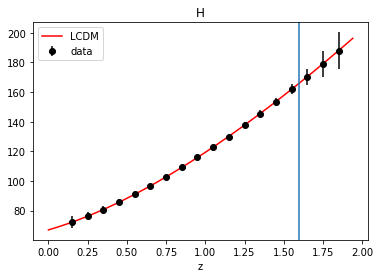

In [12]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "r-", label='LCDM')
plt.errorbar(z_arr, Hkms_data, yerr = sig_Hkms_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

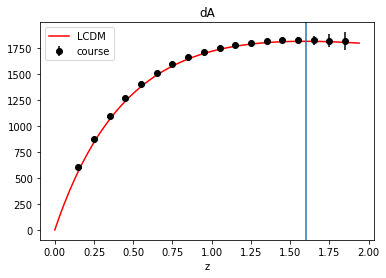

In [13]:
plt.plot(z_arr_f, Planck['dA_arr'], "r-", label='LCDM')
plt.errorbar(z_arr, dA_data, yerr = sig_dA_arr, fmt='ko', label='course')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("dA")
plt.legend();

Solve f(z) from H(z)

In [14]:
fs8_arr = Planck['f_arr']*Planck['s8_arr']
sig_fs8_arr = fs8_arr[idx]*rels_fs8/100
fs8_data = fs8_arr[idx] #+ np.random.randn(len(z_arr))*sig_fs_arr

In [15]:
data = np.concatenate([H_data, dA_data, fs8_data])

In [16]:
data

array([2.40863716e-04, 2.54384173e-04, 2.69387125e-04, 2.85801896e-04,
       3.03552741e-04, 3.22563359e-04, 3.42759923e-04, 3.64072921e-04,
       3.86438097e-04, 4.09796792e-04, 4.31625066e-04, 4.59287525e-04,
       4.85328677e-04, 5.12180711e-04, 5.39808920e-04, 5.68182077e-04,
       5.97272031e-04, 6.27053341e-04, 6.00276596e+02, 8.74687501e+02,
       1.09214206e+03, 1.26470198e+03, 1.40153371e+03, 1.50972074e+03,
       1.59480667e+03, 1.66117254e+03, 1.71230763e+03, 1.75100897e+03,
       1.77708191e+03, 1.79969978e+03, 1.81300086e+03, 1.82064775e+03,
       1.82363552e+03, 1.82278295e+03, 1.81876604e+03, 1.81214461e+03,
       4.52493573e-01, 4.64370393e-01, 4.70150158e-01, 4.70982533e-01,
       4.67953110e-01, 4.62015004e-01, 4.53966577e-01, 4.44453023e-01,
       4.33980535e-01, 4.22938057e-01, 4.12755618e-01, 4.00235775e-01,
       3.88948206e-01, 3.77865759e-01, 3.67064275e-01, 3.56593700e-01,
       3.46484682e-01, 3.36753554e-01])

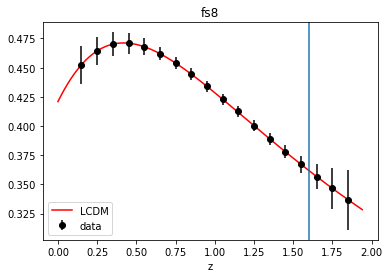

In [17]:
plt.plot(z_arr_f, fs8_arr, "r-", label='LCDM')
plt.errorbar(z_arr, fs8_data, yerr = sig_fs8_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("fs8")
plt.legend();

Training selection 

In [18]:
z_cut = 2
z_train = z_arr[z_arr<z_cut]
z_train_f = z_arr_f[z_arr_f<z_cut]
a_train_f = 1/(1+z_train_f) 
x_train_f = np.log(a_train_f)
Hkms_train = Hkms_data[z_arr<z_cut]
H_train = H_data[z_arr<z_cut]
dA_train = dA_data[z_arr<z_cut]
fs_train = fs8_data[z_arr<z_cut]
background = Planck['Hkms_arr'][z_arr_f<z_cut]

Make covariance matrices

In [19]:
Hkms_cov = np.zeros([len(z_train), len(z_train)])
H_cov = np.zeros([len(z_train), len(z_train)])
dA_cov = np.zeros([len(z_train), len(z_train)])
fs8_cov = np.zeros([len(z_train), len(z_train)])
for i in np.arange(len(z_train)):
    Hkms_cov[i,i] = sig_Hkms_arr[i]**2
    H_cov[i,i] = sig_H_arr[i]**2
    dA_cov[i,i] = sig_dA_arr[i]**2
    fs8_cov[i,i] = sig_fs8_arr[i]**2
    
data_cov = np.block([[H_cov, np.zeros_like(H_cov), np.zeros_like(H_cov)],
                 [np.zeros_like(H_cov), dA_cov, np.zeros_like(H_cov)],
                 [np.zeros_like(H_cov), np.zeros_like(H_cov), fs8_cov]])

In [20]:
hdghdg sjd

SyntaxError: invalid syntax (<ipython-input-20-05b17e2a0b4c>, line 1)

# Get mean of GP
We are not using this at the moment

In [ ]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
def _wrap_f(f, z, Wm, q):
    dfdz = (-1/(1+z))*((3/2)*Wm(z) - f**2 - q(z)*f)
    return dfdz

def _wrap_sigma8(s8, z, f):
    dsigma8dz = (-1/(1+z))*(f(z)*s8)
    return dsigma8dz

def make_f(H, z_arr, H0, Wm0, Df):  
    a_arr = 1/(1+z_arr) 
    x_arr = np.log(a_arr)
    #Make Wm
    fz0 = 0.9546646309188112 #1-Df
    Wm =  Wm0*(H0/H)**2*(1+z_arr)**3
    #Make q
    comf_H = a_arr*H
    diff_comf_H = np.gradient(comf_H)/np.gradient(x_arr)
    q = 1 + diff_comf_H/comf_H

    Wm_inter = interp1d(z_arr, Wm, kind='cubic', bounds_error=False, fill_value='extrapolate')
    q_inter = interp1d(z_arr, q, kind='cubic', bounds_error=False, fill_value='extrapolate')

    f = odeint(_wrap_f, fz0, z_arr[::-1], args=(Wm_inter, q_inter))

    return  np.array(f.flatten()[::-1])
    
def make_sigma8(f, z_arr, sigma80):  
    f_inter = interp1d(z_arr, f, kind='cubic', bounds_error=False, fill_value='extrapolate')
    sigma8 = odeint(_wrap_sigma8, sigma80, z_arr, args=(f_inter,))

    return  np.array(sigma8.flatten())

In [ ]:
from scipy.optimize import least_squares
def loss_func(coeffs, data, cov, z_output, z_data):
    H0 = coeffs[0]
    H1 = coeffs[1]
    H2 = coeffs[2]
    Wm0 = coeffs[3]
    sigma80 = coeffs[4]
    Df = coeffs[5]
    idx = np.array([int(x) for x in z_data/dz_f])
    inv_cov = np.linalg.inv(data_cov)
    Hkms_arr = tools.H_model(z_output, coeffs)
    H_arr = Hkms_arr*1000/c
    dA_arr = tools.make_dM(H_arr, z_output)/(1+z_output)
    f_arr = make_f(Hkms_arr, z_output, H0, Wm0, Df)
    s8_arr = make_sigma8(f_arr, z_output, sigma80)
    fs8_arr = f_arr*s8_arr
    theory = np.concatenate([H_arr[idx], dA_arr[idx], fs8_arr[idx]])
    diff = data - theory
    xi2 = np.dot(np.dot(diff, inv_cov), diff)
    return np.sqrt(xi2)

def get_H_fit(z_output, z_data):
    x0 = [70, 30, 30, 0.3, 0.8, 0.05]
    x = least_squares(loss_func, x0, args=(data, data_cov, z_output, z_data))
    best_coeffs = x['x']
    print(best_coeffs)
    return best_coeffs, tools.H_model(z_output, best_coeffs)

In [ ]:
best_coeffs, Hkms_fit = get_H_fit(z_arr_f, z_arr)

In [ ]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, Hkms_fit, 'b-', label = 'Best fit')
plt.errorbar(z_arr, Hkms_data, yerr = sig_H_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

In [ ]:
H0 = best_coeffs[0]
H1 = best_coeffs[1]
H2 = best_coeffs[2]
Wm0 = best_coeffs[3]
sigma80 = best_coeffs[4]
Df = best_coeffs[5]

In [ ]:
f_fit = make_f(Hkms_fit, z_arr_f, H0, Wm0, Df  )
sigma8_fit = make_sigma8(f_fit, z_arr_f, sigma80)

In [ ]:
plt.plot(z_arr_f, Planck['f_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, f_fit, 'b-', label = 'Best fit')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

In [ ]:
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, sigma8_fit*f_fit, 'b-', label = 'Best fit')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

In [ ]:
dhgefgwe 

# Set up GP

The key point of Pymc3 is that the GP is treated pseudo-numerically. what I mean by this is that when Pymc3 initializes the Gaussian process it creates an array of realizations of the GP over a given array of redshifts. The problem is that the GP is not really an array but a tensor and the entries are not numbers but symbolic variables that stand for the potential values of the GP realizations during the sampling process.  

Thus when performing operations we want to create a symbolic graph for the role of each realization of the GP in the numerical algorithm we employ to transform the GP. 

In [24]:
n_tune = 100
n_samples = 100

In [ ]:
with pm.Model() as model:
    H0 = pm.Normal('H0', mu=70 , sigma=5)
    H1 = pm.Normal('H1', mu=35 , sigma=5)
    H2 = pm.Normal('H2', mu=35 , sigma=5)
    #Mean of the gp
    H_f = pm.Deterministic('H_f',
               tt.as_tensor_variable(H0+H1*z_train_f+(1/2)*H2*z_train_f**2))
    
    #Numerical integration scheme
    dH_f = pm.Deterministic("dH_f", tt.as_tensor_variable((c/1000)/H_f))
    dA_f = tt.zeros(len(z_train_f))
    dA_f = tt.inc_subtensor(dA_f[1:],
              tt.as_tensor_variable(dz_f*tt.cumsum(dH_f)[:-1]/(1+z_train_f)[1:]))
    dA_f = pm.Deterministic('dA_f', dA_f)

    #Second order differentiation scheme
    Wm0 = 0.3158 #m.Uniform("Wm0", 0, 1) #0.3158 
    Wm =  pm.Deterministic("Wm", Wm0*(H0/H_f)**2*(1+z_train_f)**3)
    comf_H = pm.Deterministic("comf_H", a_train_f*H_f)
    diff_comf_H = tt.zeros(len(z_train_f))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_train_f[1]-x_train_f[0]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_train_f[2:]-x_train_f[:-2]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_train_f[-1]-x_train_f[-2]))
    diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
    q = 1+(diff_comf_H/comf_H)
    
    #Implement second Order Runge-Kutta method
    Df = pm.Normal("Df", mu=0.057, sigma=0.00015) 
    f0 = pm.Deterministic('f0', 1-Df) 
    f_f = tt.zeros(len(z_train_f))
    f_f = tt.inc_subtensor(f_f[-1], f0)
    for i in np.arange(1, len(z_train_f)):
        k0 = (-1/(1+z_train_f[-i]))*((3/2)*Wm[-i]-f_f[-i]**2-q[-i]*f_f[-i])
        f1 = f_f[-i]-dz_f*k0
        k1 = (-1/(1+z_train_f[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
        f_f = tt.inc_subtensor(f_f[-(i+1)], f_f[-i]-dz_f*(k1+k0)/2)
    f_f = pm.Deterministic("f_f", f_f) 
    
    #Integrate for s8 method1
    #s80 = 0.811 #pm.Uniform("s80", 0.7, 1.1)
    #s8_gp_f = tt.ones(len(z_arr_f))
    #s8_gp_f = tt.inc_subtensor(s8_gp_f[1:], tt.exp(dz_f*tt.cumsum(-f_gp_f/(1+z_arr_f)))[:-1])
    #s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f*s80) 
    
    #integrate for s8 method2
    s80 = pm.Normal("s80", mu=0.811, sigma=0.01)
    s8_f = tt.zeros(len(z_train_f))
    s8_f = tt.inc_subtensor(s8_f[0], s80)
    for i in np.arange(1, len(z_train_f)):
        k0 = -1*(f_f[i-1]*s8_f[i-1])/(1+z_train_f[i-1])
        s8_f = tt.inc_subtensor(s8_f[i], s8_f[i-1] + dz_f*(k0))
    s8_f = pm.Deterministic("s8_f", s8_f) 
    
    fs8_f = f_f*s8_f
    fs8_f = pm.Deterministic("fs8_f", fs8_f) 
    
    #Evaluate arrays at data points
    idx = np.array([int(x) for x in z_train/dz_f])
    H = pm.Deterministic('H', tt.as_tensor_variable(H_f[idx]*(1000/c)))
    dA = pm.Deterministic('dA', tt.as_tensor_variable(dA_f[idx]))
    fs8 = pm.Deterministic('fs8', tt.as_tensor_variable(fs8_f[idx]))
    
    theory = tt.concatenate([H, dA, fs8])

    #Set up Gaussian likelihoods
    lkl = pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)

    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['Hkms_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], Hkms_data, yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["s8_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['s8_arr'], "b-", label='LCDM')

# axis labels and title
plt.xlabel("z")
plt.ylabel("s8(z)")
plt.title("s8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['f_arr'], "b-", label='LCDM')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], fs8_data, yerr=sig_fs8_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [25]:
with pm.Model() as model:
    #Define parameters
    ℓ = pm.InverseGamma("ℓ", alpha=2, beta=1) 
    η = pm.HalfNormal("η", sigma=8) 
    gp_cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    H0 = pm.Normal('H0', mu=70 , sigma=5)
    H1 = pm.Normal('H1', mu=35 , sigma=5)
    H2 = pm.Normal('H2', mu=35 , sigma=5)
    #Mean of the gp
    H_f = pm.Deterministic('H_f',
               tt.as_tensor_variable(H0+H1*z_train_f+(1/2)*H2*z_train_f**2))
    
    #Set up Gaussian process
    DH_gp_f = gp.prior("DH_gp_f", X=z_train_f[:, None]) 
    H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(DH_gp_f+H_f)) 
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp_f[0])) 
    
    #Numerical integration scheme
    dH_gp_f = pm.Deterministic("dH_f", tt.as_tensor_variable((c/1000)/H_gp_f))
    dA_gp_f = tt.zeros(len(z_train_f))
    dA_gp_f = tt.inc_subtensor(dA_gp_f[1:],
              tt.as_tensor_variable(dz_f*tt.cumsum(dH_gp_f)[:-1]/(1+z_train_f)[1:]))
    dA_gp_f = pm.Deterministic('dA_gp_f', dA_gp_f)
    
    #Second order differentiation scheme
    Wm0 = pm.Uniform("Wm0", 0, 1) #0.3158 
    Wm =  pm.Deterministic("Wm", Wm0*(H0_gp/H_gp_f)**2*(1+z_train_f)**3)
    comf_H = pm.Deterministic("comf_H", a_train_f*H_gp_f)
    diff_comf_H = tt.zeros(len(z_train_f))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_train_f[1]-x_train_f[0]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_train_f[2:]-x_train_f[:-2]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_train_f[-1]-x_train_f[-2]))
    diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
    q = 1+(diff_comf_H/comf_H)
    
    #Implement second Order Runge-Kutta method
    Df = pm.Normal("Df", mu=0.057, sigma=0.00015) 
    f0 = pm.Deterministic('f0', 1-Df) 
    f_gp_f = tt.zeros(len(z_train_f))
    f_gp_f = tt.inc_subtensor(f_gp_f[-1], f0)
    for i in np.arange(1, len(z_train_f)):
        k0 = (-1/(1+z_train_f[-i]))*((3/2)*Wm[-i]-f_gp_f[-i]**2-q[-i]*f_gp_f[-i])
        f1 = f_gp_f[-i]-dz_f*k0
        k1 = (-1/(1+z_train_f[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
        f_gp_f = tt.inc_subtensor(f_gp_f[-(i+1)], f_gp_f[-i]-dz_f*(k1+k0)/2)
    f_gp_f = pm.Deterministic("f_gp_f", f_gp_f) 
    
    #Integrate for s8 method1
    #s80 = 0.811 #pm.Uniform("s80", 0.7, 1.1)
    #s8_gp_f = tt.ones(len(z_arr_f))
    #s8_gp_f = tt.inc_subtensor(s8_gp_f[1:], tt.exp(dz_f*tt.cumsum(-f_gp_f/(1+z_arr_f)))[:-1])
    #s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f*s80) 
    
    #integrate for s8 method2
    s80 = pm.Normal("s80", mu=0.811, sigma=0.01)
    s8_gp_f = tt.zeros(len(z_train_f))
    s8_gp_f = tt.inc_subtensor(s8_gp_f[0], s80)
    for i in np.arange(1, len(z_train_f)):
        k0 = -1*(f_gp_f[i-1]*s8_gp_f[i-1])/(1+z_train_f[i-1])
        s8_gp_f = tt.inc_subtensor(s8_gp_f[i], s8_gp_f[i-1] + dz_f*(k0))
    s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f) 
    
    fs8_gp_f = f_gp_f*s8_gp_f
    fs8_gp_f = pm.Deterministic("fs8_gp_f", fs8_gp_f) 
    
    #Evaluate arrays at data points
    idx = np.array([int(x) for x in z_train/dz_f])
    H_gp = pm.Deterministic('H_gp', tt.as_tensor_variable(H_gp_f[idx]*(1000/c)))
    dA_gp = pm.Deterministic('dA_gp', tt.as_tensor_variable(dA_gp_f[idx]))
    fs8_gp = pm.Deterministic('fs8_gp', tt.as_tensor_variable(fs8_gp_f[idx]))

    theory = tt.concatenate([H_gp, dA_gp, fs8_gp])

    #Set up Gaussian likelihoods
    lkl = pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)

    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s80, Df, Wm0, DH_gp_f_rotated_, H2, H1, H0, η, ℓ]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2949 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9997442042073479, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9321291855627445, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9481690846569819, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not mat

<ipython-input-26-e1138b7d907f>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  fig = pm.traceplot(trace)
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/jaimerz/.local/lib/python3

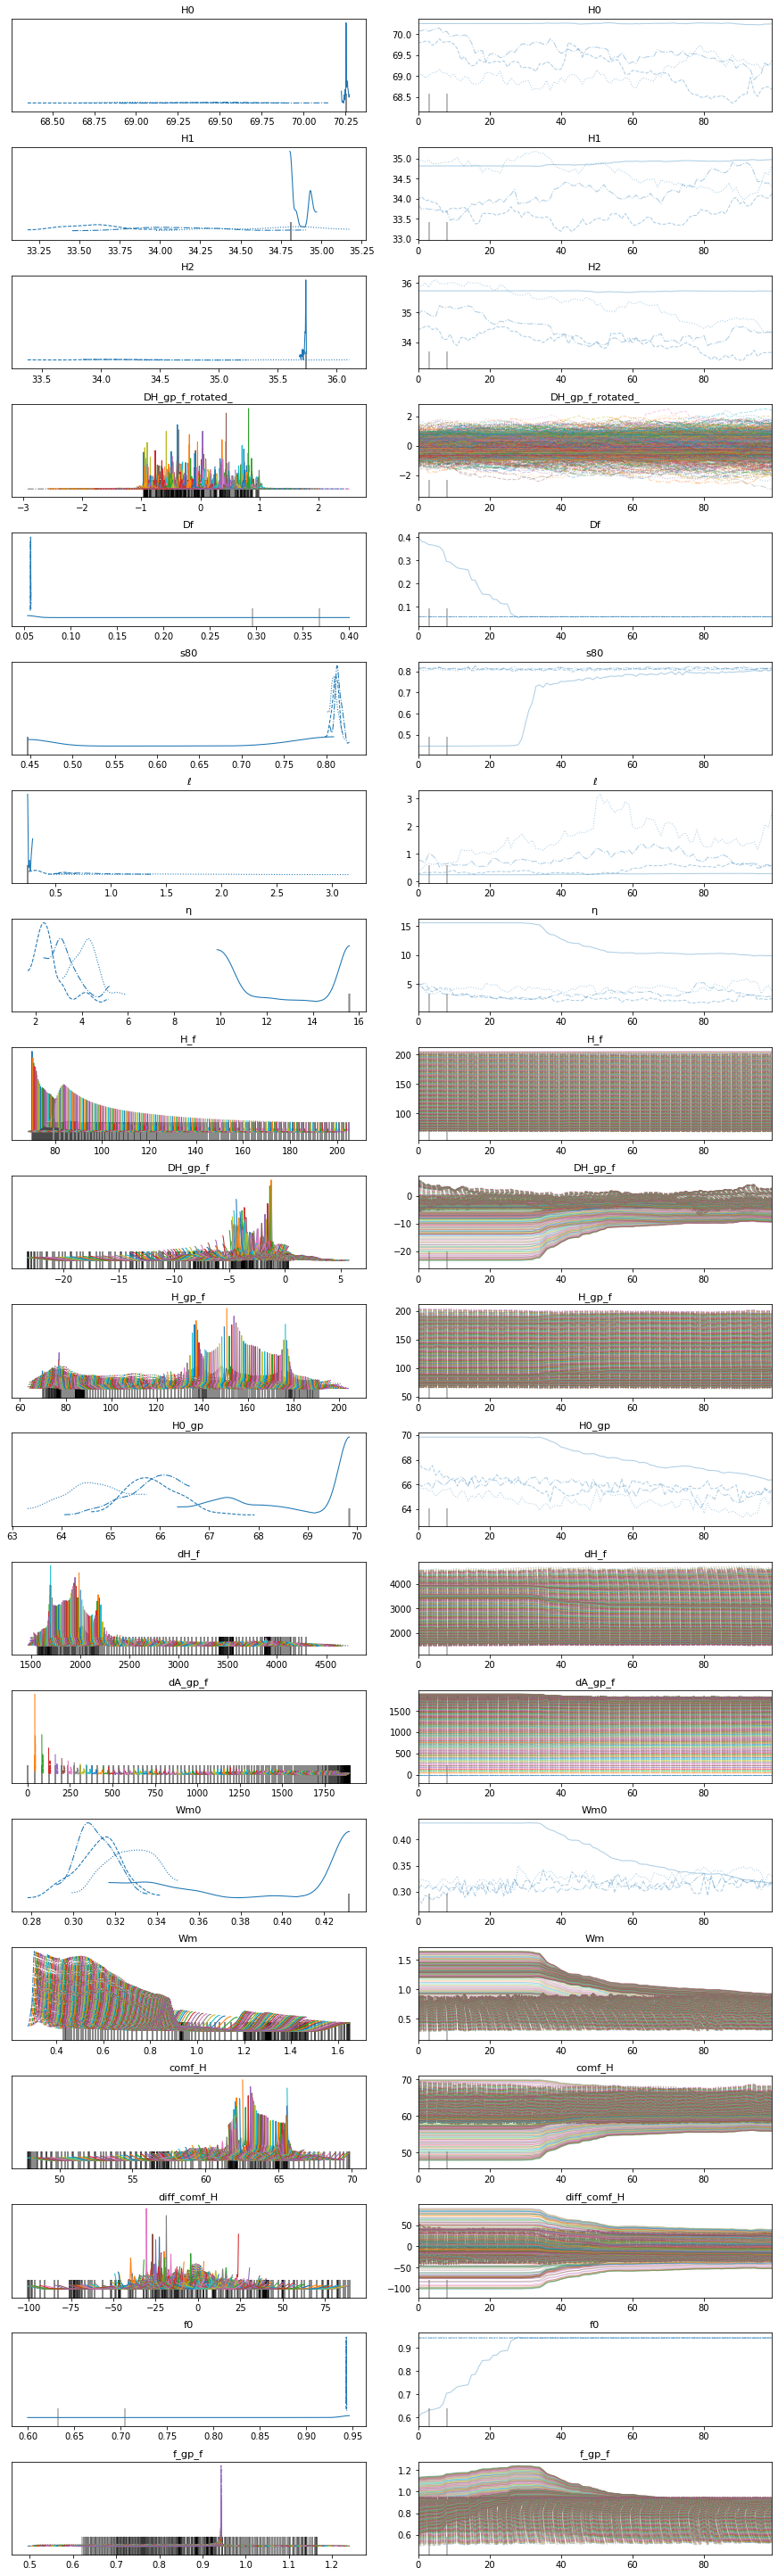

In [26]:
fig = pm.traceplot(trace)

In [27]:
R_stat =pm.summary(trace)['r_hat'][["ℓ","η", "H0_gp"]]
print(R_stat)

/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


ℓ        2.99
η        2.53
H0_gp    2.47
Name: r_hat, dtype: float64


In [ ]:
pm.summary(trace)

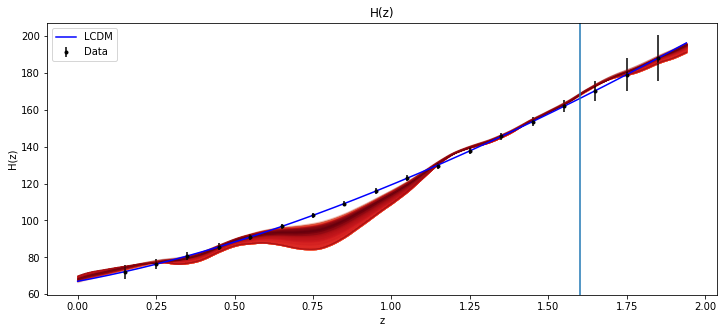

In [31]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['Hkms_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], Hkms_data, yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

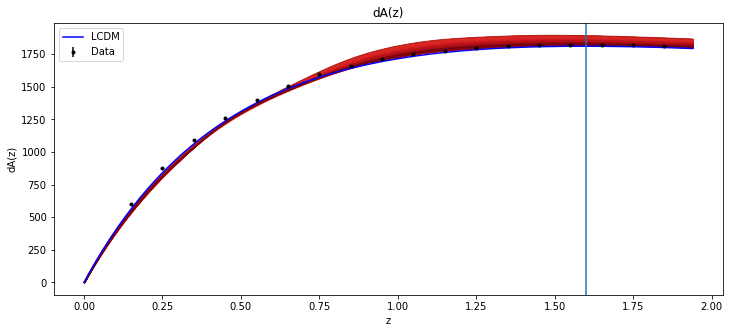

In [29]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dA_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['dA_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], dA_data, yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("dA(z)")
plt.title("dA(z)")
plt.legend();

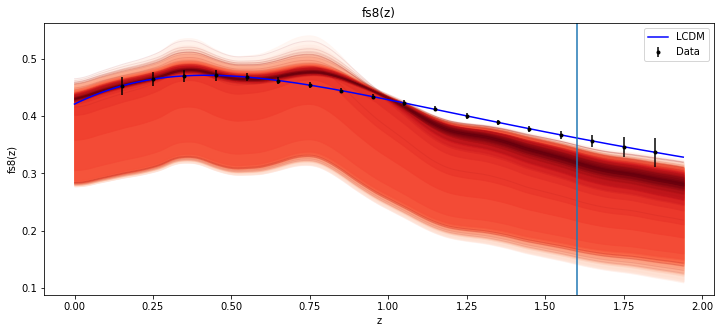

In [35]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], fs8_data, yerr=sig_fs8_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

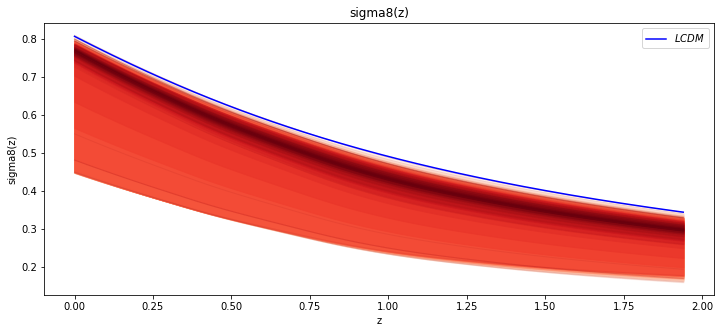

In [36]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["s8_gp_f"])[0, :, :], z_train_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['s8_arr'], "b-", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("sigma8(z)")
plt.legend();

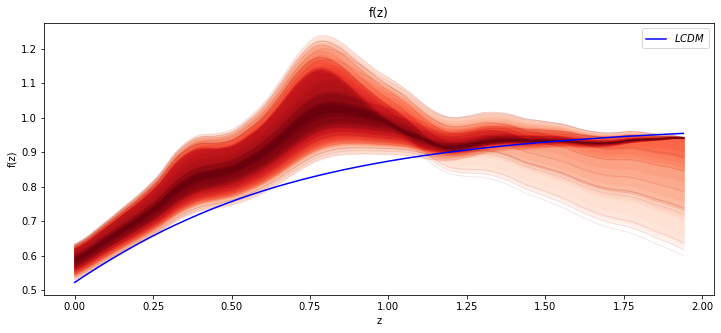

In [37]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["f_gp_f"])[0, :, :], z_train_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['f_arr'], "b-", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();

In [ ]:
#z_new
# add the GP conditional to the model, given the new X values
z_new = np.arange(0., 3+0.1, 0.01)[:, None]
with model:
    DHkms_pred = gp.conditional("DHkms_pred", z_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["DHkms_pred"])

In [ ]:
Hkms_new = np.array([])
for z in z_new: 
            #We can worry about the rs_drag later
            Hkms = classy.Hubble(z)*utils.c/1000
            Hkms_new = np.append(Hkms_new, Hkms)

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["DHkms_pred"]+Hkms_new, z_new)
# plot the data and the true latent function
plt.plot(z_new, Hkms_new, "dodgerblue", lw=2, label="LCDM")
ax.errorbar(z_arr[:, None], Hkms_data , yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel(r'$Hkms$')
#plt.ylim([-1.3, 4])
#plt.xlim([0, 3])
plt.legend();

# Validation

In [ ]:
z_test = z_arr[z_arr>z_cut]
z_test_f = z_arr_f[z_arr_f>z_cut]
a_test_f = 1/(1+z_test_f) 
x_test_f = np.log(a_test_f)
Hkms_test = Hkms_data[z_arr>z_cut]
H_test = H_data[z_arr>z_cut]
dA_test = dA_data[z_arr>z_cut]
fs_test = fs_data[z_arr>z_cut]
background = Hkms_arr_f[z_arr_f>z_cut]

In [ ]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [ ]:
prediction = (pred_samples["DHkms_pred"]+Hkms_new)[idx]
pred_m, pred_s = get_m_s(prediction)

In [ ]:
idx = np.array([int(x) for x in z_test/dz_f])
pred_data = pred_m[idx]
pred_err = sig_Hkms_arr[z_arr>1.6]

In [ ]:
residuals = (Hkms_test-pred_data)/pred_err

In [ ]:
plt.plot(z_test_f, np.zeros_like(z_test_f), 'b--')
plt.plot(z_test, residuals, 'ro', label='residuals')
plt.fill_between(z_test_f, np.ones_like(z_test_f), -np.ones_like(z_test_f), color='b', alpha=.3)
plt.fill_between(z_test_f, 2*np.ones_like(z_test_f), -2*np.ones_like(z_test_f), color='b', alpha=.3)
plt.xlabel("z")
plt.legend();

In [ ]:
xi2 = np.sqrt(np.dot((Hkms_test-pred_data)/pred_err, (Hkms_test-pred_data)/pred_err))/3

In [ ]:
xi2

In [ ]:
path = 'DESIfs8_Planck_fit_{}_{}'.format(n_samples, n_tune)

DH_pred = pred_samples['DHkms_pred']
Hz =np.array(trace.posterior["H_gp_f"])
Hz = Hz.reshape(-1, Hz.shape[-1])
dAz = np.array(trace.posterior["dA_gp_f"])
dAz = dAz.reshape(-1, dAz.shape[-1])
fz = np.array(trace.posterior["f_gp_f"])
fz= fz.reshape(-1, fz.shape[-1])
sigma8z = np.array(trace.posterior["s8_gp_f"])
sigma8z = sigma8z.reshape(-1, sigma8z.shape[-1])
fs8z = np.array(trace.posterior["fs8_gp_f"])
fs8z = fs8z.reshape(-1, fs8z.shape[-1])
n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
Df = np.array(trace.posterior["Df"]).flatten()
H0 = np.array(trace.posterior["H0_gp"]).flatten()
Omega_m = np.array(trace.posterior["Wm0"]).flatten()
sigma8 = np.array(trace.posterior["s80"]).flatten()

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         DH_pred = DH_pred,
         z_new = z_new,
         Hz=Hz,
         dAz=dAz,
         fz=fz,
         sigma8z=sigma8z,
         fs8z=fs8z,
         n=n,
         l=l,
         Df=Df,
         H0=H0,
         Omega_m=Omega_m,
         sigma8=sigma8)